In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, f1_score

pd.options.display.float_format = '{:,.6f}'.format

# Data Understanding

In [2]:
data = pd.read_csv('online_shoppers_intention.csv')
data.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.000000,0,0.000000,2,64.000000,0.000000,0.100000,0.000000,0.000000,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,Feb,4,1,9,3,Returning_Visitor,False,False


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

## Target distribution

In [4]:
data['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

**distribusi data target memiliki kondisi imbalance**

In [5]:
temp = data.copy()
temp.Revenue = temp.Revenue.astype('int')

<AxesSubplot:>

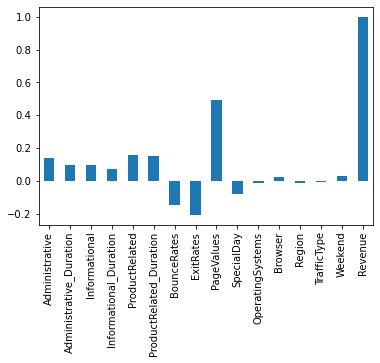

In [6]:
temp.corr()['Revenue'].plot(kind='bar')

**Page value memiliki korelasi yang paling tinggi terhadap target**

# Simple data Preparation

In [7]:
data.head(4)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.000000,0,0.000000,2,64.000000,0.000000,0.100000,0.000000,0.000000,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.000000,0,0.000000,2,2.666667,0.050000,0.140000,0.000000,0.000000,Feb,3,2,2,4,Returning_Visitor,False,False


## Data cleaning

In [8]:
data.duplicated().sum()

125

In [9]:
data = data.drop_duplicates()

In [10]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [11]:
data = data.dropna().reset_index(drop=True)

## Convert target to numeric

In [12]:
data.Revenue = data.Revenue.astype('int')

## Use numerical only

In [13]:
data_temp = data.select_dtypes(include=np.number)
data_temp.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Revenue
0,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,1,1,1,1,0
1,0,0.000000,0,0.000000,2,64.000000,0.000000,0.100000,0.000000,0.000000,2,2,1,2,0
2,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,4,1,9,3,0
3,0,0.000000,0,0.000000,2,2.666667,0.050000,0.140000,0.000000,0.000000,3,2,2,4,0
4,0,0.000000,0,0.000000,10,627.500000,0.020000,0.050000,0.000000,0.000000,3,3,1,4,0


## Target distribution

In [14]:
data_temp['Revenue'].value_counts()

0    10297
1     1908
Name: Revenue, dtype: int64

## Split dataset

In [15]:
X = data_temp.drop('Revenue', axis=1)
y = data_temp[['Revenue']]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [18]:
list_model = [
                LogisticRegression(),
                DecisionTreeClassifier(),
                RandomForestClassifier(),
                xgb.XGBClassifier()    
]

df = pd.DataFrame(columns = ['Method','F1 Score', 'Classification Report'])

for model in list_model:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    method = str(type(model)).split('.')[-1][:-2]
    
    # AUC Score
    f1  = f1_score(y_test, y_pred)
    c_report = classification_report(y_test, y_pred, digits=6)
    
    df = df.append({'Method': method,  
                    'F1 Score' : f1,
                    'Classification Report': c_report},
                     ignore_index=True)


In [20]:
df['status'] = 'data test'
df

,Method,F1 Score,Classification Report,status
0,LogisticRegression,0.513120,precision recall f1-score ...,data test
1,DecisionTreeClassifier,0.511577,precision recall f1-score ...,data test
2,RandomForestClassifier,0.636591,precision recall f1-score ...,data test
3,XGBClassifier,0.612943,precision recall f1-score ...,data test


In [25]:
list_model = [
                LogisticRegression(),
                DecisionTreeClassifier(),
                RandomForestClassifier(),
                xgb.XGBClassifier()    
]

df_train = pd.DataFrame(columns = ['Method','F1 Score', 'Classification Report'])

for model in list_model:
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    method = str(type(model)).split('.')[-1][:-2]
    
    # AUC Score
    f1  = f1_score(y_train, y_pred_train)
    c_report = classification_report(y_train, y_pred_train, digits=6)
    
    df_train = df_train.append({'Method': method,  
                    'F1 Score' : f1,
                    'Classification Report': c_report},
                     ignore_index=True)

In [26]:
df_train['status'] = 'data train'
df_train

,Method,F1 Score,Classification Report,status
0,LogisticRegression,0.518551,precision recall f1-score ...,data train
1,DecisionTreeClassifier,1.000000,precision recall f1-score ...,data train
2,RandomForestClassifier,1.000000,precision recall f1-score ...,data train
3,XGBClassifier,0.932418,precision recall f1-score ...,data train


## Detail Evaluation

In [26]:
print(df[df['Method']=='LogisticRegression']['Classification Report'].values[0])

              precision    recall  f1-score   support

           0   0.899681  0.975029  0.935841      2603
           1   0.718615  0.369710  0.488235       449

    accuracy                       0.885976      3052
   macro avg   0.809148  0.672370  0.712038      3052
weighted avg   0.873043  0.885976  0.869991      3052



In [27]:
print(df[df['Method']=='DecisionTreeClassifier']['Classification Report'].values[0])

              precision    recall  f1-score   support

           0   0.914132  0.912025  0.913077      2603
           1   0.496703  0.503341  0.500000       449

    accuracy                       0.851900      3052
   macro avg   0.705417  0.707683  0.706538      3052
weighted avg   0.852721  0.851900  0.852306      3052



In [28]:
print(df[df['Method']=='RandomForestClassifier']['Classification Report'].values[0])

              precision    recall  f1-score   support

           0   0.927434  0.962351  0.944570      2603
           1   0.720798  0.563474  0.632500       449

    accuracy                       0.903670      3052
   macro avg   0.824116  0.762913  0.788535      3052
weighted avg   0.897035  0.903670  0.898659      3052



In [29]:
print(df[df['Method']=='XGBClassifier']['Classification Report'].values[0])

              precision    recall  f1-score   support

           0   0.926174  0.954284  0.940019      2603
           1   0.678378  0.559020  0.612943       449

    accuracy                       0.896134      3052
   macro avg   0.802276  0.756652  0.776481      3052
weighted avg   0.889720  0.896134  0.891901      3052

